# Weighted Least Squares

## What is Weighted Least Squares (WLS)?

**Weighted Least Squares (WLS)** is a variation of the Ordinary Least Squares (OLS) method. In OLS, it's assumed that the variance of the errors (residuals) is constant across all observations. This assumption is called **homoscedasticity**. However, in many real-world scenarios, this assumption doesn't hold; the errors might be larger for some observations than for others. This situation is called **heteroscedasticity**.

When heteroscedasticity is present, OLS gives equal weight to all data points. This can lead to inefficient parameter estimates (meaning the estimates are not the most precise possible) and incorrect standard errors, which in turn affect the reliability of confidence intervals and hypothesis tests.

WLS addresses this by assigning different **weights** to each data point in the regression. The goal of WLS is to minimize the sum of the *weighted* squared residuals:

$$\sum_{i=1}^{n} w_i (y_i - f(x_i, \beta))^2$$

where:
* $w_i$ is the weight for the $i$-th data point.
* $y_i$ is the observed dependent variable for the $i$-th point.
* $f(x_i, \beta)$ is the predicted value from the model for the $i$-th point, with parameters $\beta$.

**How are weights determined?**
The weights are typically inversely proportional to the variance of the errors for each observation. If $\sigma_i^2$ is the variance of the error for the $i$-th observation, then the weight $w_i$ is usually $1/\sigma_i^2$. This means:
* Observations with smaller errors (lower variance) get larger weights, influencing the fit more.
* Observations with larger errors (higher variance) get smaller weights, influencing the fit less.

In your specific case, where you defined a $\pm 0.5$ error for most points and a negligible error for the first point, you are effectively providing `curve_fit` with the standard deviations ($\sigma_i$) of your measurements. The function then internally squares these to get the variances and uses their inverses as weights. The point with `sigma = 1e-9` gets an extremely large weight, forcing the fitted curve to pass almost exactly through that point.



### What are `sigma` and `absolute_sigma` parameters in `scipy.optimize.curve_fit`?

1.  **`sigma`**:
    * This parameter takes an `M`-length sequence (where `M` is the number of data points) or an `MxM` array.
    * If it's an `M`-length sequence (which is what we used), it represents the **standard deviations** of the `ydata` points. So, `sigma[i]` is the estimated standard deviation of `ydata[i]`.
    * `curve_fit` then uses these standard deviations to perform a weighted least squares minimization. The weights applied are `w_i = 1 / sigma[i]**2`.
    * If `sigma` is not provided, `curve_fit` assumes uniform errors (homoscedasticity), equivalent to all `sigma[i]` being 1, which defaults to Ordinary Least Squares (OLS).

2.  **`absolute_sigma`**:
    * This is a boolean parameter, defaulting to `False`.
    * **`absolute_sigma = False` (Default):** This is the more common scenario for relative weighting. When `sigma` is provided and `absolute_sigma` is `False`, `curve_fit` scales the covariance matrix (`pcov`) by `chisq / (M - N)`, where `chisq` is the reduced chi-squared value (sum of squared weighted residuals), `M` is the number of data points, and `N` is the number of parameters. This scaling effectively assumes that the provided `sigma` values are *relative* estimates of the uncertainties, and the overall scaling factor is determined by the goodness of fit to the data. This means that if your model fits the data very well (small reduced chi-squared), the parameter uncertainties in `pcov` will be smaller, and vice-versa.
    * **`absolute_sigma = True`:** When `sigma` is provided and `absolute_sigma` is `True`, `curve_fit` treats the provided `sigma` values as **absolute standard deviations** of the `ydata`. In this case, no scaling of the covariance matrix (`pcov`) is performed based on the goodness of fit. The `pcov` directly reflects the uncertainties implied by the provided `sigma` values. This is appropriate when you have precise knowledge of the absolute errors in your measurements. This is generally what you want when your `sigma` values come from known measurement uncertainties (like your $\pm 0.5$ error).

In your updated code, using `sigma=sigma, absolute_sigma=True` is the correct approach because you have known, absolute uncertainties for your Y values.

### What algorithm is running if we use `sigma` parameters?

Regardless of whether you provide `sigma` or not, `scipy.optimize.curve_fit` internally uses a **Levenberg-Marquardt algorithm** by default to find the parameters that minimize the sum of squared residuals.

The key difference when `sigma` is provided is *what* the Levenberg-Marquardt algorithm minimizes:

* **Without `sigma` (OLS):** It minimizes the ordinary sum of squared residuals: $\sum (y_i - f(x_i, \beta))^2$.
* **With `sigma` (WLS):** It minimizes the **weighted sum of squared residuals**: $\sum w_i (y_i - f(x_i, \beta))^2$, where $w_i = 1 / \sigma_i^2$.

The Levenberg-Marquardt algorithm is an iterative numerical optimization algorithm. It cleverly switches between a steepest descent method (when far from the minimum) and the Gauss-Newton method (when close to the minimum) to efficiently converge to the optimal parameter values. When `sigma` is provided, the function being minimized (the objective function) simply changes from the unweighted sum of squares to the weighted sum of squares, but the core optimization algorithm remains Levenberg-Marquardt.

You can actually specify other optimization algorithms for `curve_fit` using the `method` parameter (e.g., `'trf'` for Trust Region Reflective, or `'dogbox'` for dogleg algorithm), but Levenberg-Marquardt (`'lm'`) is the default and often a good choice for non-linear least squares problems. The concept of weighting applies similarly regardless of the specific algorithm used for minimization, as long as that algorithm supports minimizing a weighted sum of squares.


--- Fitting Dataset 1 ---
Sigma for Dataset 1: [1.e-09 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01]
Fitted parameters: A = 93.5355 +/- 0.8080, B = 0.0270 +/- 0.0005
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696

--- Fitting Dataset 2 ---
Sigma for Dataset 2: [1.e-09 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01]
Fitted parameters: A = 75.2997 +/- 0.4209, B = 0.0110 +/- 0.0002
Sum of Squared Residuals (SSR): 134.1877
Root Mean Squared Error (RMSE): 4.3783
Total Sum of Squares (TSS): 4934.4171
R-squared: 0.9728
Adjusted R-squared: 0.9592

--- Fitting Dataset 3 ---
Sigma for Dataset 3: [1.e-09 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01]
Fitted parameters: A = 56.6753 +/- 0.4506, B = 0.0099 +/- 0.0002
Sum of Squared Residuals (SSR): 1.8090
Root Mean Squared Error (RMSE): 0.5084
Total Sum of Squares (TSS): 2811.9943
R-squared: 0.9994
Adjusted R-squared: 0.9990


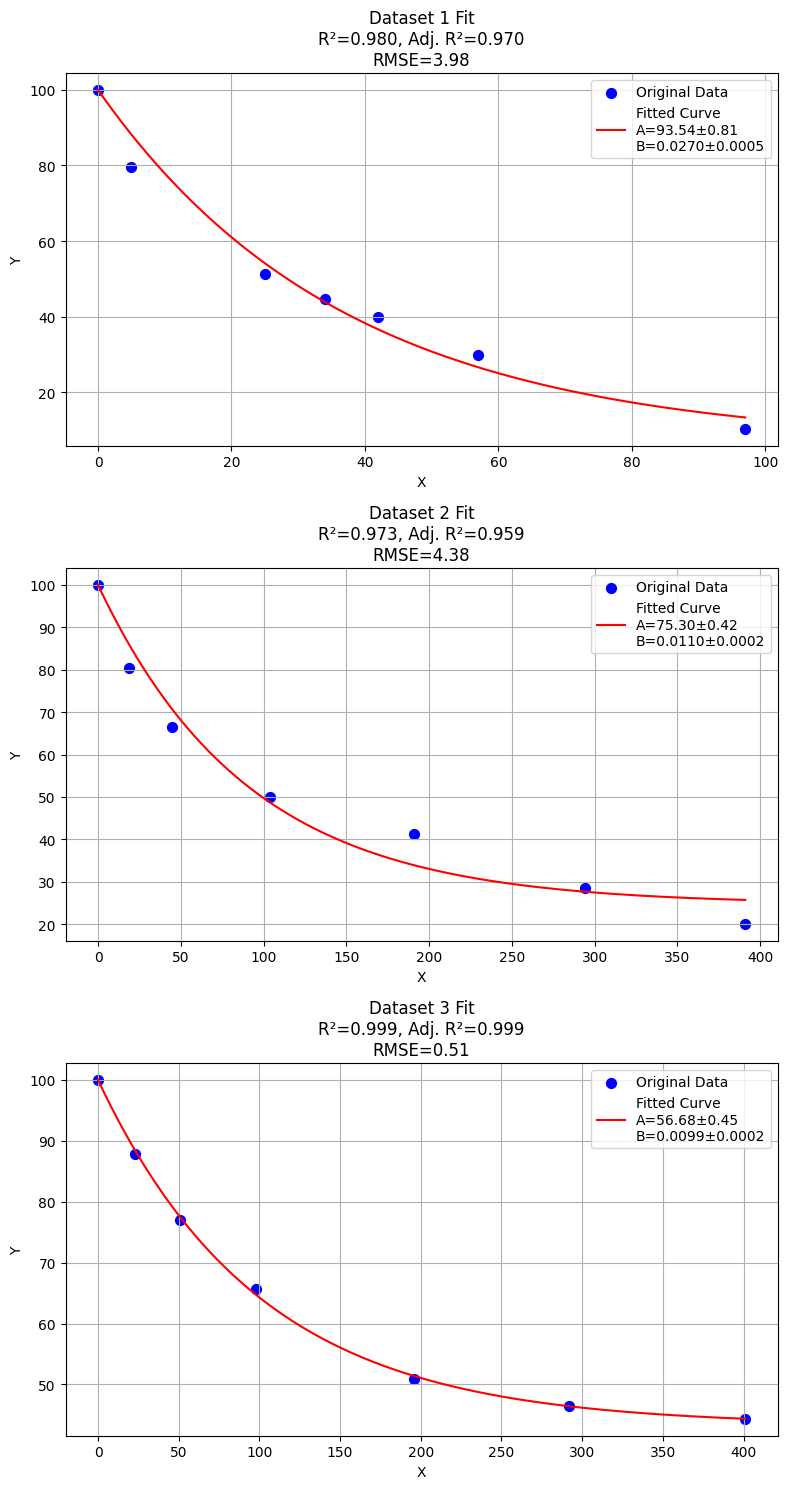

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# 1. Define the function to fit
def custom_function(x, A, B):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    return A * (np.exp(-B * x) - 1) + 100

# 2. Prepare the datasets
# Dataset 1
data1_x = np.array([0, 5, 25, 34, 42, 57, 97])
data1_y = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])

# Dataset 2
data2_x = np.array([0, 19, 45, 104, 191, 294, 391])
data2_y = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])

# Dataset 3
data3_x = np.array([0, 23, 51, 98, 196, 292, 401])
data3_y = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])

# Combine datasets into a list for easier iteration
datasets = [
    {"name": "Dataset 1", "x": data1_x, "y": data1_y},
    {"name": "Dataset 2", "x": data2_x, "y": data2_y},
    {"name": "Dataset 3", "x": data3_x, "y": data3_y},
]

# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 0.5, dtype=float)
    sigma[0] = 1e-9  # Very small error for the first point
    print(f"Sigma for {dataset['name']}: {sigma}")


    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })

# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()